In [3]:
from __init__ import subject_number, path_data, columns, path_model # 共通変数（ファイルパスなど）のインポート
import sys
sys.dont_write_bytecode = True # __pycache__を消す

In [2]:
import pandas as pd
import glob

# ファイルパスを取得
file_paths = glob.glob(path_data + '/*.csv')

# すべてのCSVファイルを読み込んでDataFrameに結合
dfs = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dfs, ignore_index=True)

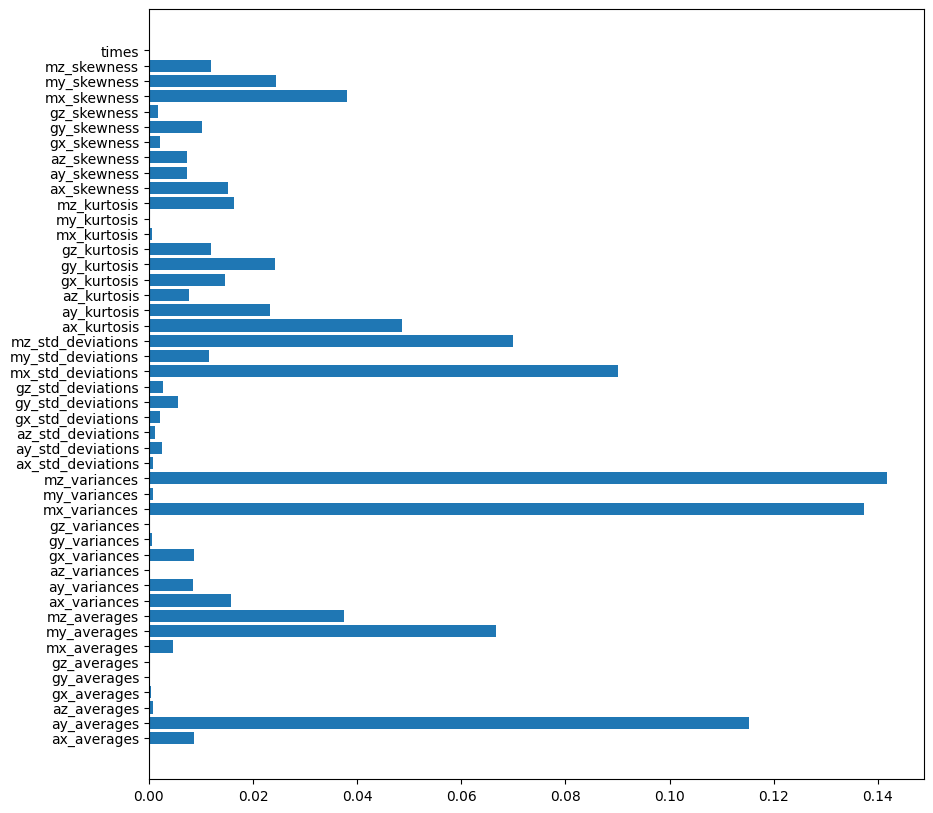

アンダーバギングの正解率: 1.0


In [3]:
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
import pickle
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
import numpy as np

# 行列の標準化
dfs = df.iloc[:, 1:].apply(lambda x: (x-x.mean())/x.std(), axis=0)

X = dfs   # 特徴量データ
y = df['class'].apply(lambda x: 1 if x != subject_number else 0)  # ラベルデータ：ユーザの場合0，ユーザ以外を1

# アンダーサンプリング
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# ランダムフォレストモデルの作成
rf_model = RandomForestClassifier()

# アンダーバギングのパラメータ
n_subsets = 10  # サブセットの数
predictions = np.zeros((len(X_resampled), n_subsets))

# アンダーバギングの実行
for i in range(n_subsets):
    # アンダーサンプリングを実行
    X_subset, y_subset = undersampler.fit_resample(X, y)
    
    # ランダムフォレストモデルの訓練と予測
    rf_model.fit(X_subset, y_subset)
    predictions[:, i] = rf_model.predict(X_resampled)

# 各特徴量の重要度
labels = dfs.columns
importances = rf_model.feature_importances_  
plt.figure(figsize = (10,10))
plt.barh(y = range(len(importances)), width = importances)
plt.yticks(ticks = range(len(labels)), labels = labels)
plt.show()

# アンサンブルの予測を平均化してラベルを取得
ensemble_labels = (np.mean(predictions, axis=1) > 0.5).astype(int)

# 正解率の計算
accuracy = accuracy_score(y_resampled, ensemble_labels)
print("アンダーバギングの正解率:", accuracy)

pickle.dump(rf_model, open(path_model, 'wb'))